# Demo para analizar y estudiar las imágenes disponibles de TIPOS de ANIMALES


In [1]:
#@title Librerías a usar
import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os

from PIL import Image, ExifTags, ImageStat

from sklearn import tree
from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans
  
import ipywidgets as widgets
from ipywidgets import Box, Layout
from IPython.display import clear_output

print("Librerías cargadas")

Librerías cargadas


In [2]:
#@title Funciones Auxiliares

# variables auxiliares 
atributo_clase = ""

# configura para que muestre todas las columnas y filas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# devuelve listas de columnas numéricas y no numéricas
def devolNombreColumnas(ndf):
  colValues = []
  colNoValues = []
  for col in ndf.columns:
    if ndf[col].dtypes in ("object", "bool"):
      colNoValues.append( col )
    else:
      colValues.append( col )
  return colValues, colNoValues

# función auxiliar para separar datos de entrada y de salida
def separarDatosXY(ndf, atributo_clase="", xSoloNros=True):
  # hace una copia auxiliar del data frame
  cdf = ndf.copy()
  # saca el atributo clase (OPCIONAL)
  if atributo_clase == "":
    Y = []
  else:
    # datos atributo clase
    Y = np.array( cdf.pop(atributo_clase).fillna("-NAN-") )
  if xSoloNros:
    # se queda sólo con los atributos numéricos (OPCIONAL)
    for col in cdf.columns:
      if cdf[col].dtypes == "object":
          cdf.pop( col )
  # datos de entrada
  X = np.array(cdf.fillna(0.001))
  return X, Y, np.array(cdf.columns)

def convColsNumericas(ndf, atributos_no_convertir = []):
  # hace una copia auxiliar del data frame
  cdf = ndf.copy()
  # convierte todas las no numéricas a numéricas (OPCIONAL)
  for col in cdf.columns:
    if col not in atributos_no_convertir:
      if cdf[col].dtypes == "object":
        # genera diccionario de valores
        valores = cdf[col].unique()
        diccValores = dict(zip(valores, range(len(valores))))
        # realiza el reemplazo
        cdf[col] = cdf[col].map(lambda s: diccValores.get(s) if s in diccValores else s)
  return cdf
  
# función auxiliar
def generar_estadisticas_detalladas(orDF, titulo=""):
  # título
  print("\n", titulo, ": ") 
  # obtiene las estadísticas generales
  estDF = orDF.describe().transpose()
  #  genera y formatea las estadísticas
  if "min" in estDF and "max" in estDF:
    rangoValores = "[ " + estDF["min"].apply('{:.2f}'.format) + " ; " + estDF["max"].apply('{:.2f}'.format) + " ]"    
  else:
    rangoValores = estDF["unique"].fillna(0.0).apply('{:.0f}'.format)
  rangoValores.name = "Rango Valores"
  # para campos no numéricos muestra las cantidades por valor
  for col in orDF.columns:
    if orDF[col].dtypes in ("object", "bool"):
      auxStr = str( orDF[col].value_counts() ).replace("\n", " ; ")
      if (auxStr.index("Name")-3) > 0:
        # saca lo del final porque no sirve
        auxStr = auxStr[:auxStr.index("Name")-3]
      rangoValores[col] = "{ " + auxStr + " }"
  if "mean" in estDF and "std" in estDF:      
    promValores = estDF["mean"].fillna(0.0).apply('{:.3f}'.format) + " ± " + estDF["std"].fillna(0.0).apply('{:.3f}'.format)
  else:
    promValores = estDF["count"].apply('{:.0f}'.format)
  promValores.name = "Promedio ± Desvío"
  # obtiene valores "ceros" y nulos
  zero_val = (orDF == 0.00).astype(int).sum(axis=0)
  zero_val.name = "¿Valores Ceros?"
  mis_val = orDF.isnull().sum()
  mis_val.name = "¿Valores Nulos?"
  # prepara la nueva tabla para mostrar
  nTable = pd.concat([orDF.dtypes, rangoValores, promValores, zero_val, mis_val], axis=1)
  nTable = nTable.rename( columns = {0: 'Tipo Valor',  1: 'Rango Valores', 2: 'Promedio ± Desvío', 3: '¿Valores Ceros?', 4: '¿Valores Nulos?' } )
  # muestra la nueva tabla
  pd.set_option('max_colwidth', None)
  display(nTable.fillna("-"))
  print("Tiene " + str(orDF.shape[1]) + " atributos y " + str(orDF.shape[0]) + " ejemplos.")
  print("\n")
  return 

print("Funciones auxiliares definidas.")

Funciones auxiliares definidas.


# Carga de los Datos:

In [3]:
#@title Montar Google Drive { run: "auto" }

# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

#@markdown ### Directorio  en Google Drive:
path = 'gdrive/My Drive/IA/demo ANIMALES/imagenes' #@param {type:"string"}

#@markdown ### Subdirectorios de imágenes:
path_entrenamiento = '/train'  #@param {type:"string"}
path_validacion = ''  #@param {type:"string"}
path_prueba = '/test'  #@param {type:"string"}

# función auxiliar
def controlarPath(paths_imagenes, path, subdir, tipoUso):
  if path != "" and subdir != "":
    pCompleto = path + subdir
    if os.path.isdir(pCompleto):
      print("Usando imágenes de " + tipoUso + ": ", pCompleto)
      paths_imagenes.append( (pCompleto, tipoUso) )
    else:
      print("Error: El directorio de " + tipoUso + " ", pCompleto, " no existe!!!")


# define path completo y verifica que existan
paths_imagenes = []
controlarPath(paths_imagenes, path, path_entrenamiento, "entrenamiento")
controlarPath(paths_imagenes, path, path_validacion, "validacion")
controlarPath(paths_imagenes, path, path_prueba, "prueba")
    

Mounted at /content/gdrive
Usando imágenes de entrenamiento:  gdrive/My Drive/IA/demo ANIMALES/imagenes/train
Usando imágenes de prueba:  gdrive/My Drive/IA/demo ANIMALES/imagenes/test


In [4]:
#@title Cargar información de las Imágenes { run: "auto" }

# parámetros de información a cargar
incluir_info_Path = True #@param {type:"boolean"}
incluir_info_Estadisticas_Imagen = True #@param {type:"boolean"}
incluir_info_Extra_Imagen = False #@param {type:"boolean"}
incluir_info_EXIF_Imagen = False #@param {type:"boolean"}

# función auxiliar para agregar elemenos al diccionario
# si no sabemos si es lista o valor 
# nota: lo hace recursivo para manejar datos anidados
def agregarInfoDic(dicc, clave, valor):
  if isinstance(valor, (list, tuple, np.ndarray, np.ndenumerate)):
    # si es lista, entonces agrega una columna por elemento de la lista
    i = 0
    while i < len(valor):
      #dicc[clave+"_"+str(i)] = valor[i]
      agregarInfoDic(dicc, clave+"_"+str(i), valor[i])
      i = i + 1
  elif isinstance(valor, dict):
    # si es un diccionario, entonces agrega una columna por elemento de la lista
    for k in valor.keys():
      #dicc[clave+"_"+str(k)] = valor[k]
      agregarInfoDic(dicc, clave+"_"+str(k), valor[k])      
  elif isinstance(valor, bytes):
     # si es bytes, lo tranforma a ASCII
     dicc[clave] = str(valor.decode("utf-8", "ignore"))
  else:
    # sino agrega directo el valor
    dicc[clave] = valor

# define función para cargar información de las imágenes
def cargarInfoImagenes(imagPath, tipoUso, incluirInfoEstadImag=False, incluirInfoExtraImag=False, incluirInfoEXIF=False, incluirInfoPath=False, stringDA='' ):
  print("\n")
  if imagPath is None or imagPath == "":
    print("Error: no se indica el path de las imágenes.")
    return []
  if tipoUso == "":
    print("> Procesando imágenes:")
  else:
    print("> Procesando imágenes de ", tipoUso, ":")
  # inicializa valores
  cantMostrar = 10
  infoImag = []
  all_dirs = os.listdir( imagPath )
  for each_dir in all_dirs:    
    # controla que sea un subdirectorio
    auxiPath = imagPath + '/' + each_dir 
    if os.path.isdir(auxiPath):
      # procesa por subdirectorio de CLASE
      imagFN  = os.listdir( auxiPath )      
      clase = each_dir
      totalMostrar = len(imagFN)
    else:
      # procesa el archivo
      imagFN = [ each_dir ]
      auxiPath = imagPath + '/' 
      clase = ""
      totalMostrar = -1
    # auxiliar para mosrar progreso
    cant = 0    
    for each_imagFN in imagFN:
      if totalMostrar > 0:
        cant = cant + 1
        if ((cantMostrar>0) and ((cant%cantMostrar)==0)) or (cant==totalMostrar):
          print("  -- subdirectorio ", each_dir, ":  procesando ", cant, " imágenes de ", totalMostrar)
      # inicializa el diccionario
      dicInfo = {}
      # carga la información base
      if tipoUso != "":
        dicInfo["TipoUso"] = tipoUso        
      dicInfo["Imagen"] = each_imagFN
      if clase != "":
        dicInfo["Clase"] = clase
      # abre la imagen y obtiene información general
      img = Image.open(auxiPath+"/"+each_imagFN)
      dicInfo["Img_Ancho"] = img.width
      dicInfo["Img_Alto"] = img.height
      dicInfo["Img_Modo"] = img.mode
      if incluirInfoEstadImag: 
        # obtiene información estadistica de la imagen
        # si se quieren agregar más, ver https://pillow.readthedocs.io/en/stable/reference/ImageStat.html 
        statImg = ImageStat.Stat(img)
        for b, c, m, s in zip(img.getbands(), statImg.count, statImg.mean, statImg.stddev):
            b = b.upper()
            if b == "B":
              banda = "Azul"
            elif b == "G":
              banda = "Verde"
            elif b == "R":
              banda = "Rojo"
            elif b == "A":
              banda = "Alfa"
            else:
              banda = b
            dicInfo["Pixeles_"+banda+"_Total"] = c
            dicInfo["Pixeles_"+banda+"_Promedio"] = m
            dicInfo["Pixeles_"+banda+"_Desvio"] = s
      if incluirInfoExtraImag:
        # obtiene información extra de la imagen
        for key in img.info.keys():
          #dicInfo[key] = img.info[key]
          if key != "exif":
            agregarInfoDic(dicInfo, "Img_"+key, img.info[key])
      if incluirInfoEXIF:
        #  obtiene la información EXIF de la imagen
        exif_data = img._getexif()
        if exif_data is None:
          dicInfo["TieneEXIF"] = False
        else:
          dicInfo["TieneEXIF"] = True
          if isinstance(exif_data, bytes):
              exif_data = exif_data.decode()            
          for key, val in exif_data.items():
            if key in ExifTags.TAGS:
              strK = "EXIF_"+ExifTags.TAGS[key]
            elif key in ExifTags.GPSTAGS:
              strK = "EXIF_"+ExifTags.GPSTAGS[key]          
            else:
              strK = "EXIF_"+str(key)
            #dicInfo[ExifTags.TAGS[key]] = val
            agregarInfoDic(dicInfo, strK, val)
      if incluirInfoPath:
        # obtiene información sobre path y tipo archivo
        dicInfo["Archivo_Path"] = auxiPath
        dicInfo["Archivo_Nombre"] = os.path.splitext(each_imagFN)[0]
        dicInfo["Archivo_Extension"] = os.path.splitext(each_imagFN)[1].upper()
        dicInfo["Archivo_TamBytes"] =os.path.getsize(auxiPath+"/"+each_imagFN)
      if stringDA != '':
        # determina si es una imagen generada por data augmentation
        dicInfo["Archivo_EsDA"] = (each_imagFN[:2] == stringDA)             
      # agrega la información a la lista
      infoImag.append( dicInfo )
  print("  == se cargan ", len(infoImag), "imágenes ==")
  return infoImag

# carga las imagenes de acuerdo a los path definidos antes
todaInfo = []
for p in paths_imagenes:
  auxInfo = cargarInfoImagenes(p[0], 
                                       tipoUso = p[1], 
                                       incluirInfoEstadImag = incluir_info_Estadisticas_Imagen,
                                       incluirInfoExtraImag = incluir_info_Extra_Imagen,
                                       incluirInfoEXIF = incluir_info_EXIF_Imagen,
                                       incluirInfoPath = incluir_info_Path,
                                       stringDA = 'da')
  todaInfo.extend( auxInfo )

# se genera el data frame con los datos cargados
if len(todaInfo) == 0:
  print("\nNo se ha podido cargar la información de las imágenes!")
  ndf = None
else:
  ndf = pd.DataFrame( todaInfo )  
  print("\n> Información cargada de las imágenes: ")
  display( ndf )



> Procesando imágenes de  entrenamiento :
  -- subdirectorio  mamifero :  procesando  10  imágenes de  17
  -- subdirectorio  mamifero :  procesando  17  imágenes de  17
  -- subdirectorio  invertebrado :  procesando  10  imágenes de  17
  -- subdirectorio  invertebrado :  procesando  17  imágenes de  17
  -- subdirectorio  insecto :  procesando  10  imágenes de  17
  -- subdirectorio  insecto :  procesando  17  imágenes de  17
  -- subdirectorio  pez :  procesando  10  imágenes de  17
  -- subdirectorio  pez :  procesando  17  imágenes de  17
  -- subdirectorio  reptil :  procesando  10  imágenes de  17
  -- subdirectorio  reptil :  procesando  17  imágenes de  17
  -- subdirectorio  ave :  procesando  10  imágenes de  17
  -- subdirectorio  ave :  procesando  17  imágenes de  17
  == se cargan  102 imágenes ==


> Procesando imágenes de  prueba :
  -- subdirectorio  ave :  procesando  10  imágenes de  10
  -- subdirectorio  insecto :  procesando  10  imágenes de  10
  -- subdirecto

,TipoUso,Imagen,Clase,Img_Ancho,Img_Alto,Img_Modo,Pixeles_Rojo_Total,Pixeles_Rojo_Promedio,Pixeles_Rojo_Desvio,Pixeles_Verde_Total,Pixeles_Verde_Promedio,Pixeles_Verde_Desvio,Pixeles_Azul_Total,Pixeles_Azul_Promedio,Pixeles_Azul_Desvio,Pixeles_Alfa_Total,Pixeles_Alfa_Promedio,Pixeles_Alfa_Desvio,Archivo_Path,Archivo_Nombre,Archivo_Extension,Archivo_TamBytes,Archivo_EsDA
0,entrenamiento,m_caballo.png,mamifero,320,320,RGBA,102400,48.045791,72.776413,102400,26.813945,42.854748,102400,12.186240,22.361457,102400.0,85.975254,119.432543,gdrive/My Drive/IA/demo ANIMALES/imagenes/trai...,m_caballo,.PNG,67657,False
1,entrenamiento,m_delfin.png,mamifero,320,320,RGBA,102400,18.183027,40.778407,102400,61.839609,86.407164,102400,59.047461,83.124007,102400.0,85.837393,120.082317,gdrive/My Drive/IA/demo ANIMALES/imagenes/trai...,m_delfin,.PNG,17937,False
2,entrenamiento,m_tigre.png,mamifero,320,320,RGBA,102400,76.585938,100.656542,102400,48.962197,73.268487,102400,22.693975,58.102148,102400.0,100.933184,123.593976,gdrive/My Drive/IA/demo ANIMALES/imagenes/trai...,m_tigre,.PNG,107350,False
3,entrenamiento,m_elefante.png,mamifero,320,320,RGBA,102400,74.078545,71.646612,102400,70.847090,68.705471,102400,97.921689,89.500568,102400.0,135.162187,125.029722,gdrive/My Drive/IA/demo ANIMALES/imagenes/trai...,m_elefante,.PNG,51944,False
4,entrenamiento,m_jabali.png,mamifero,320,320,RGBA,102400,46.214277,68.814404,102400,23.133408,42.810138,102400,18.494463,37.834449,102400.0,91.172900,121.379109,gdrive/My Drive/IA/demo ANIMALES/imagenes/trai...,m_jabali,.PNG,94470,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,prueba,da_reptil_1_3597687.png,reptil,256,256,RGB,65536,21.677078,48.857077,65536,71.404861,77.135321,65536,39.824219,46.201212,NaN,NaN,NaN,gdrive/My Drive/IA/demo ANIMALES/imagenes/test...,da_reptil_1_3597687,.PNG,33404,True
158,prueba,da_reptil_2_4181974.png,reptil,256,256,RGB,65536,40.751053,79.083700,65536,30.671524,62.761179,65536,34.264359,67.934055,NaN,NaN,NaN,gdrive/My Drive/IA/demo ANIMALES/imagenes/test...,da_reptil_2_4181974,.PNG,25886,True
159,prueba,da_reptil_3_9959169.png,reptil,256,256,RGB,65536,100.792465,99.648161,65536,108.690582,107.994238,65536,64.941208,67.973023,NaN,NaN,NaN,gdrive/My Drive/IA/demo ANIMALES/imagenes/test...,da_reptil_3_9959169,.PNG,81495,True
160,prueba,da_reptil_6_7461699.png,reptil,256,256,RGB,65536,59.793930,78.487432,65536,57.578568,76.085799,65536,10.745148,25.616985,NaN,NaN,NaN,gdrive/My Drive/IA/demo ANIMALES/imagenes/test...,da_reptil_6_7461699,.PNG,43626,True


In [5]:
#@title Mostrar Estadísticas Generales de la Información cargada de las Imágenes { run: "auto" }

# muestra las estadísticas
generar_estadisticas_detalladas(ndf, "> Estadísticas de los datos cargados") 



 > Estadísticas de los datos cargados : 


,Tipo Valor,Rango Valores,Promedio ± Desvío,¿Valores Ceros?,¿Valores Nulos?
TipoUso,object,{ entrenamiento 102 ; prueba 60 },-,0,0
Imagen,object,{ r_cocodrilo.png 2 ; r_serpiente.png 2 ; s_cucaracha.png 2 ; s_abeja.png 2 ; a_buho.png 2 ; .. ; da_pez_2_3262184.png 1 ; da_mamifero_2_8265165.png 1 ; da_pez_8_415006.png 1 ; da_mamifero_7_8534901.png 1 ; m_elefante.png 1 },-,0,0
Clase,object,{ ave 27 ; invertebrado 27 ; reptil 27 ; pez 27 ; insecto 27 ; mamifero 27 },-,0,0
Img_Ancho,int64,[ 256.00 ; 320.00 ],279.704 ± 31.002,0,0
Img_Alto,int64,[ 256.00 ; 320.00 ],279.704 ± 31.002,0,0
Img_Modo,object,{ RGB 102 ; RGBA 60 },-,0,0
Pixeles_Rojo_Total,int64,[ 65536.00 ; 102400.00 ],79189.333 ± 17856.968,0,0
Pixeles_Rojo_Promedio,float64,[ 6.44 ; 150.82 ],58.566 ± 28.680,0,0
Pixeles_Rojo_Desvio,float64,[ 32.94 ; 120.94 ],82.351 ± 21.600,0,0
Pixeles_Verde_Total,int64,[ 65536.00 ; 102400.00 ],79189.333 ± 17856.968,0,0


Tiene 23 atributos y 162 ejemplos.




#Preparación de los Datos:

In [6]:
#@title Seleccionar columnas de los datos (OPCIONAL) { run: "auto" }

seleccionar_columnas_datos = True #@param {type:"boolean"}

if seleccionar_columnas_datos:

  # copia de los datos
  copiaDF = ndf.copy()

  # carga las columnas numéricas y no numéricas
  todasCols = list(ndf.columns)

  # combo selección de columnas
  selColumnas = widgets.SelectMultiple(
      options=todasCols,
      value=list(todasCols),
      description='Atributos seleccionados:',
      rows=len(todasCols),
      layout=Layout(display="flex")
  )

  ui = widgets.HBox([selColumnas])


  def cambiaSeleccion(cols):
    global ndf
    # convierte la selección a un array
    arCols = np.array(cols)
    # ordena los datos
    print("\n> Se seleccionan los atributos: ", arCols)
    ndf = copiaDF[arCols]
    print("\n> 10 primeros ejemplos de los datos con menos columnas: ")
    display(ndf.head())

  out = widgets.interactive_output(cambiaSeleccion, {'cols': selColumnas})
  display(ui, out)

else:
  print("No se selecciona columnas de los datos.")


Output()

In [7]:
#@title Definir Valores Discretos para Atributo Clase (OPCIONAL) { run: "auto" }

#@markdown Nombre del atributo clase / objetivo:
atributo_clase = 'Clase' #@param {type:"string"}
#@markdown (Nota: siempre debe comienzar en 0, por lo que si no tiene valor 0, se debe agregar "na" al inicio de la lista)
mostrar_estadisticas_por_valor_clase = True #@param {type:"boolean"}

if atributo_clase != "":

  # controla que exista el atributo_clase
  if atributo_clase not in ndf:
    raise ValueError("El atributo '" + atributo_clase + "' no existe en los datos cargados!!!")

  # mostrar nuevas estadísticas por Clase
  if mostrar_estadisticas_por_valor_clase:
    for val in  ndf[atributo_clase].fillna("-NAN-").unique():
      auxDF = ndf[ ndf[atributo_clase].fillna("-NAN-") == val]
      auxDF = auxDF.drop(labels=atributo_clase, axis=1) 
      generar_estadisticas_detalladas(auxDF, "- Estadísticas por valor de clase '" + str(val) + "'" )

else:
  print("No se ha definido el nombre del atributo clase.")


 - Estadísticas por valor de clase 'mamifero' : 


,Tipo Valor,Rango Valores,Promedio ± Desvío,¿Valores Ceros?,¿Valores Nulos?
TipoUso,object,{ entrenamiento 17 ; prueba 10 },-,0,0
Imagen,object,{ m_mono.png 2 ; m_tigre.png 1 ; m_oso.png 1 ; m_panda.png 1 ; da_mamifero_5_5910879.png 1 ; da_mamifero_2_4325285.png 1 ; da_mamifero_4_8145164.png 1 ; da_mamifero_1_3143150.png 1 ; da_mamifero_0_9131387.png 1 ; da_mamifero_8_5750627.png 1 ; da_mamifero_9_1143370.png 1 ; m_elefante.png 1 ; da_mamifero_5_4533738.png 1 ; m_caballo.png 1 ; da_mamifero_0_2050048.png 1 ; da_mamifero_1_2565568.png 1 ; da_mamifero_6_8609820.png 1 ; da_mamifero_7_8534901.png 1 ; da_mamifero_2_8265165.png 1 ; m_delfin.png 1 ; da_mamifero_6_9212493.png 1 ; m_jabali.png 1 ; da_mamifero_4_2416544.png 1 ; da_mamifero_3_2864717.png 1 ; da_mamifero_3_7866349.png 1 ; m_beluga.png 1 },-,0,0
Img_Ancho,int64,[ 256.00 ; 320.00 ],279.704 ± 31.495,0,0
Img_Alto,int64,[ 256.00 ; 320.00 ],279.704 ± 31.495,0,0
Img_Modo,object,{ RGB 17 ; RGBA 10 },-,0,0
Pixeles_Rojo_Total,int64,[ 65536.00 ; 102400.00 ],79189.333 ± 18140.880,0,0
Pixeles_Rojo_Promedio,float64,[ 17.51 ; 81.63 ],49.499 ± 19.993,0,0
Pixeles_Rojo_Desvio,float64,[ 39.12 ; 100.66 ],71.840 ± 15.208,0,0
Pixeles_Verde_Total,int64,[ 65536.00 ; 102400.00 ],79189.333 ± 18140.880,0,0
Pixeles_Verde_Promedio,float64,[ 15.89 ; 76.58 ],40.995 ± 17.372,0,0


Tiene 22 atributos y 27 ejemplos.



 - Estadísticas por valor de clase 'invertebrado' : 


,Tipo Valor,Rango Valores,Promedio ± Desvío,¿Valores Ceros?,¿Valores Nulos?
TipoUso,object,{ entrenamiento 17 ; prueba 10 },-,0,0
Imagen,object,{ i_caracol.png 2 ; i_babosa.png 2 ; da_invertebrado_2_6920272.png 1 ; da_invertebrado_3_3348644.png 1 ; da_invertebrado_1_9373600.png 1 ; i_calamar.png 1 ; i_caracol 2.png 1 ; da_invertebrado_0_6800063.png 1 ; da_invertebrado_3_3960932.png 1 ; da_invertebrado_6_7298585.png 1 ; i_esponja de mar.png 1 ; i_medusa.png 1 ; da_invertebrado_7_9395132.png 1 ; da_invertebrado_6_6798445.png 1 ; i_pulpo.png 1 ; i_estrella de mar.png 1 ; da_invertebrado_1_1047436.png 1 ; da_invertebrado_0_5509586.png 1 ; da_invertebrado_5_9822208.png 1 ; da_invertebrado_5_7742294.png 1 ; da_invertebrado_2_4920823.png 1 ; da_invertebrado_9_499496.png 1 ; da_invertebrado_4_8336333.png 1 ; da_invertebrado_8_7725500.png 1 ; da_invertebrado_4_912146.png 1 },-,0,0
Img_Ancho,int64,[ 256.00 ; 320.00 ],279.704 ± 31.495,0,0
Img_Alto,int64,[ 256.00 ; 320.00 ],279.704 ± 31.495,0,0
Img_Modo,object,{ RGB 17 ; RGBA 10 },-,0,0
Pixeles_Rojo_Total,int64,[ 65536.00 ; 102400.00 ],79189.333 ± 18140.880,0,0
Pixeles_Rojo_Promedio,float64,[ 31.46 ; 134.65 ],77.915 ± 28.052,0,0
Pixeles_Rojo_Desvio,float64,[ 65.18 ; 120.94 ],96.867 ± 18.403,0,0
Pixeles_Verde_Total,int64,[ 65536.00 ; 102400.00 ],79189.333 ± 18140.880,0,0
Pixeles_Verde_Promedio,float64,[ 34.10 ; 94.33 ],60.721 ± 20.221,0,0


Tiene 22 atributos y 27 ejemplos.



 - Estadísticas por valor de clase 'insecto' : 


,Tipo Valor,Rango Valores,Promedio ± Desvío,¿Valores Ceros?,¿Valores Nulos?
TipoUso,object,{ entrenamiento 17 ; prueba 10 },-,0,0
Imagen,object,{ s_hormiga.png 2 ; s_abeja.png 2 ; s_cucaracha.png 2 ; da_insecto_0_7494650.png 1 ; da_insecto_2_7636276.png 1 ; da_insecto_2_7132090.png 1 ; s_mariposa.png 1 ; da_insecto_6_7882441.png 1 ; da_insecto_4_6405433.png 1 ; s_bichito luz.png 1 ; da_insecto_8_6508547.png 1 ; s_vaquita san antonio.png 1 ; da_insecto_5_9171483.png 1 ; da_insecto_9_5119704.png 1 ; da_insecto_5_1846654.png 1 ; da_insecto_7_3607331.png 1 ; da_insecto_3_4385155.png 1 ; da_insecto_3_9881136.png 1 ; da_insecto_1_1832568.png 1 ; da_insecto_0_2108471.png 1 ; da_insecto_6_4388806.png 1 ; s_abeja 2.png 1 ; da_insecto_4_7587915.png 1 ; da_insecto_1_1189475.png 1 },-,0,0
Img_Ancho,int64,[ 256.00 ; 320.00 ],279.704 ± 31.495,0,0
Img_Alto,int64,[ 256.00 ; 320.00 ],279.704 ± 31.495,0,0
Img_Modo,object,{ RGB 17 ; RGBA 10 },-,0,0
Pixeles_Rojo_Total,int64,[ 65536.00 ; 102400.00 ],79189.333 ± 18140.880,0,0
Pixeles_Rojo_Promedio,float64,[ 22.10 ; 150.82 ],63.571 ± 25.814,0,0
Pixeles_Rojo_Desvio,float64,[ 57.70 ; 113.54 ],89.453 ± 15.929,0,0
Pixeles_Verde_Total,int64,[ 65536.00 ; 102400.00 ],79189.333 ± 18140.880,0,0
Pixeles_Verde_Promedio,float64,[ 12.98 ; 93.90 ],48.403 ± 23.414,0,0


Tiene 22 atributos y 27 ejemplos.



 - Estadísticas por valor de clase 'pez' : 


,Tipo Valor,Rango Valores,Promedio ± Desvío,¿Valores Ceros?,¿Valores Nulos?
TipoUso,object,{ entrenamiento 17 ; prueba 10 },-,0,0
Imagen,object,{ da_pez_6_4365622.png 1 ; p_luna.png 1 ; p_espada.png 1 ; da_pez_1_2037764.png 1 ; da_pez_6_8804063.png 1 ; p_feo.png 1 ; da_pez_2_144983.png 1 ; p_piraña.png 1 ; da_pez_3_6763242.png 1 ; p_abismal.png 1 ; da_pez_4_1176031.png 1 ; da_pez_0_709119.png 1 ; p_globo.png 1 ; da_pez_2_3262184.png 1 ; da_pez_4_2619731.png 1 ; da_pez_0_2617836.png 1 ; p_payaso.png 1 ; da_pez_7_4224996.png 1 ; da_pez_5_731495.png 1 ; da_pez_1_3305455.png 1 ; p_labio.png 1 ; p_tiburon.png 1 ; da_pez_5_1287887.png 1 ; da_pez_9_3622400.png 1 ; da_pez_8_415006.png 1 ; da_pez_3_617710.png 1 ; p_atun.png 1 },-,0,0
Img_Ancho,int64,[ 256.00 ; 320.00 ],279.704 ± 31.495,0,0
Img_Alto,int64,[ 256.00 ; 320.00 ],279.704 ± 31.495,0,0
Img_Modo,object,{ RGB 17 ; RGBA 10 },-,0,0
Pixeles_Rojo_Total,int64,[ 65536.00 ; 102400.00 ],79189.333 ± 18140.880,0,0
Pixeles_Rojo_Promedio,float64,[ 13.67 ; 129.67 ],61.173 ± 32.160,0,0
Pixeles_Rojo_Desvio,float64,[ 40.62 ; 114.76 ],84.230 ± 23.740,0,0
Pixeles_Verde_Total,int64,[ 65536.00 ; 102400.00 ],79189.333 ± 18140.880,0,0
Pixeles_Verde_Promedio,float64,[ 15.14 ; 82.20 ],48.399 ± 19.207,0,0


Tiene 22 atributos y 27 ejemplos.



 - Estadísticas por valor de clase 'reptil' : 


,Tipo Valor,Rango Valores,Promedio ± Desvío,¿Valores Ceros?,¿Valores Nulos?
TipoUso,object,{ entrenamiento 17 ; prueba 10 },-,0,0
Imagen,object,{ r_dinosaurio.png 2 ; r_cocodrilo.png 2 ; r_serpiente.png 2 ; da_reptil_3_9959169.png 1 ; da_reptil_4_9190157.png 1 ; da_reptil_5_523271.png 1 ; da_reptil_2_1622137.png 1 ; r_iguana.png 1 ; da_reptil_0_1939232.png 1 ; da_reptil_9_6694277.png 1 ; r_salamandra.png 1 ; da_reptil_2_4181974.png 1 ; da_reptil_7_5082666.png 1 ; da_reptil_4_1303083.png 1 ; r_tortuga.png 1 ; da_reptil_5_502131.png 1 ; r_camaleon.png 1 ; da_reptil_8_8612741.png 1 ; da_reptil_6_1415506.png 1 ; da_reptil_1_3130922.png 1 ; da_reptil_3_355029.png 1 ; da_reptil_1_3597687.png 1 ; da_reptil_0_5699254.png 1 ; da_reptil_6_7461699.png 1 },-,0,0
Img_Ancho,int64,[ 256.00 ; 320.00 ],279.704 ± 31.495,0,0
Img_Alto,int64,[ 256.00 ; 320.00 ],279.704 ± 31.495,0,0
Img_Modo,object,{ RGB 17 ; RGBA 10 },-,0,0
Pixeles_Rojo_Total,int64,[ 65536.00 ; 102400.00 ],79189.333 ± 18140.880,0,0
Pixeles_Rojo_Promedio,float64,[ 6.44 ; 100.79 ],41.900 ± 24.203,0,0
Pixeles_Rojo_Desvio,float64,[ 32.94 ; 99.65 ],68.100 ± 20.121,0,0
Pixeles_Verde_Total,int64,[ 65536.00 ; 102400.00 ],79189.333 ± 18140.880,0,0
Pixeles_Verde_Promedio,float64,[ 13.19 ; 108.69 ],50.729 ± 23.407,0,0


Tiene 22 atributos y 27 ejemplos.



 - Estadísticas por valor de clase 'ave' : 


,Tipo Valor,Rango Valores,Promedio ± Desvío,¿Valores Ceros?,¿Valores Nulos?
TipoUso,object,{ entrenamiento 17 ; prueba 10 },-,0,0
Imagen,object,{ a_buho.png 2 ; a_tucan.png 2 ; da_ave_6_5293596.png 1 ; da_ave_4_1435960.png 1 ; da_ave_7_1847081.png 1 ; da_ave_8_7754792.png 1 ; da_ave_2_4880156.png 1 ; da_ave_5_8576502.png 1 ; da_ave_0_826608.png 1 ; da_ave_3_7460922.png 1 ; da_ave_1_9427258.png 1 ; da_ave_4_8699645.png 1 ; da_ave_9_9017432.png 1 ; da_ave_3_7129104.png 1 ; da_ave_0_6880982.png 1 ; a_pollito.png 1 ; a_gallina.png 1 ; a_pajaro.png 1 ; a_buitre.png 1 ; da_ave_5_7123249.png 1 ; da_ave_6_7316453.png 1 ; da_ave_2_4768202.png 1 ; a_pinguino.png 1 ; a_avestruz.png 1 ; da_ave_1_8131772.png 1 },-,0,0
Img_Ancho,int64,[ 256.00 ; 320.00 ],279.704 ± 31.495,0,0
Img_Alto,int64,[ 256.00 ; 320.00 ],279.704 ± 31.495,0,0
Img_Modo,object,{ RGB 17 ; RGBA 10 },-,0,0
Pixeles_Rojo_Total,int64,[ 65536.00 ; 102400.00 ],79189.333 ± 18140.880,0,0
Pixeles_Rojo_Promedio,float64,[ 21.03 ; 102.66 ],57.336 ± 28.693,0,0
Pixeles_Rojo_Desvio,float64,[ 49.24 ; 112.78 ],83.618 ± 22.246,0,0
Pixeles_Verde_Total,int64,[ 65536.00 ; 102400.00 ],79189.333 ± 18140.880,0,0
Pixeles_Verde_Promedio,float64,[ 17.97 ; 100.53 ],52.884 ± 26.223,0,0


Tiene 22 atributos y 27 ejemplos.




In [8]:
#@title Ordenar los datos (OPCIONAL) { run: "auto" }

ordenar_valores_datos = False #@param {type:"boolean"}

if ordenar_valores_datos:

  # carga las columnas numéricas y no numéricas
  todasCols = list(ndf.columns)

  # combo selección de columnas
  selColumnas = widgets.SelectMultiple(
      options=todasCols,
      value=list(todasCols),
      description='Atributos seleccionados:',
      rows=len(todasCols),
      layout=Layout(display="flex")
  )

  ui = widgets.HBox([selColumnas])


  def cambiaSeleccion(cols):
    global ndf
    # convierte la selección a un array
    arCols = np.array(cols)
    # ordena los datos
    print("\n> Ordenando por atributos: ", arCols)
    ndf = ndf.sort_values(by=list(arCols))
    print("\n> 10 primeros ejemplos de los datos ordenados: ")
    display(ndf.head())

  out = widgets.interactive_output(cambiaSeleccion, {'cols': selColumnas})
  display(ui, out)

else:
  print("No se ordenan los datos.")


No se ordenan los datos.


In [9]:
#@title Convertir atributos no numéricos a numéricos (OPCIONAL) { run: "auto" }

convertir_valores_noNumericos_a_Numericos = False #@param {type:"boolean"}
#@markdown (Nota: si está definido el atributo clase / objetivo se mantiene como no numérico)

# convierte a valores numéricos
if convertir_valores_noNumericos_a_Numericos:
  ndf = convColsNumericas(ndf, [atributo_clase])

  # mostrar estadísticas generales
  generar_estadisticas_detalladas(ndf, "> Nuevas Estadísticas Generales valores convertidos") 
else:
  print("No se aplica la conversión a valores numéricos.")

No se aplica la conversión a valores numéricos.


In [10]:
#@title Controlar valores duplicados (OPCIONAL) { run: "auto" }

#@markdown Muesta ejemplos con los valores iguales:
detectar_ejemplos_duplicados = True #@param {type:"boolean"}

if detectar_ejemplos_duplicados:  

  # carga las columnas numéricas y no numéricas
  todasCols = list(ndf.columns)

  # combo selección de columnas
  selColumnas = widgets.SelectMultiple(
      options=todasCols,
      value=list(todasCols),
      description='Atributos seleccionados:',
      rows=len(todasCols),
      layout=Layout(display="flex")
  )

  ui = widgets.HBox([selColumnas])

  dups = None

  # Botones de acciones
  def mostrarDups(b):
    with output:
      clear_output()
      global dups, ndf
      if dups is not None and len(ndf[dups])>0:
        display( ndf[dups] )
      else:
        print("No hay duplicados para mostrar!")
  def mostrarEstDups(b):    
    with output:
      clear_output()
      global dups, ndf
      if dups is not None and len(ndf[dups])>0:
        generar_estadisticas_detalladas(ndf[dups], "Estadística de ejemplos duplicados")
      else:
        print("No hay duplicados para mostrar!")
  def eliminarDups(b):    
    with output:
      clear_output()
      global dups, ndf
      if dups is not None and len(ndf[dups])>0:
        ndf = ndf[~dups]
        cambiaSeleccionDup(selColumnas.value)
        print(" Ejemplos duplicados eliminados.")
      else:
        print("No hay duplicados para eliminar!")

      
  layoutButton = widgets.Layout(width='auto', height='40px') #set width and height
  buttonMD = widgets.Button(description="Mostrar Datos Duplicados",    
                            display='flex',
                            flex_flow='column',
                            align_items='stretch', 
                            layout = layoutButton)
  buttonMD.on_click(mostrarDups)  
  buttonMeD = widgets.Button(description="Mostrar Estadísticas Duplicados",
                            display='flex',
                            flex_flow='column',
                            align_items='stretch', 
                            layout = layoutButton)
  buttonMeD.on_click(mostrarEstDups)
  buttonED = widgets.Button(description="Eliminar Duplicados",
                            display='flex',
                            flex_flow='column',
                            align_items='stretch', 
                            layout = layoutButton)
  buttonED.on_click(eliminarDups)
  output = widgets.Output()


  def cambiaSeleccionDup(cols):
    global dups
    # convierte la selección a un array
    arCols = np.array(cols)
    print("\n> Resultados de controlar ejemplos duplicados con atributos seleccionados: ")
    # detecta los ejemplos duplicados 
    # (al primero le pone 'False' y los siguientes iguales se marcan con 'True')
    dups = ndf.duplicated(subset=arCols, keep="first") 
    # muestra las cantidades
    cantDup = len(ndf[dups])
    cantNoDup = len(ndf[~dups])
    print("   - Cantidad de ejemplos con todos los valores duplicados = ", cantDup, "(", round((cantDup/(cantDup+cantNoDup))*100,1), "%)")
    print("   + Cantidad de ejemplos con valores diferentes = ", cantNoDup, "(", round((cantNoDup/(cantDup+cantNoDup))*100,1), "%)")
    print("   = Cantidad total de ejemplos = ", (cantDup+cantNoDup))

    if cantDup > 0:      
      # si hay duplicados
      print("\n> Posibles acciones a realizar:")
      display(buttonMD, buttonMeD, buttonED, output)
    

  out = widgets.interactive_output(cambiaSeleccionDup, {'cols': selColumnas})
  display(ui, out)

else:
  print("No se controlan datos duplicados.")


Output()

In [11]:
#@title Normalizar datos numéricos (OPCIONAL) { run: "auto" }

aplica_normalizacion = False #@param {type:"boolean"}
#@markdown Si se aplica, seleccione el tipo de método de normalización a aplicar:
tipo_normalizacion = "MinMax Scaler" #@param ["Standard Scaler", "MinMax Scaler", "MaxAbs Scaler", "Robust Scaler"]

if aplica_normalizacion:

  print("10 primeros ejemplos antes de normalizar: ")
  display( ndf.head() )

  from sklearn import preprocessing

  # elegir el método de normalización
  if tipo_normalizacion == "Standard Scaler": 
    scaler = preprocessing.StandardScaler()
  elif tipo_normalizacion == "MinMax Scaler": 
    scaler = preprocessing.MinMaxScaler()
  elif tipo_normalizacion == "MaxMax Scaler": 
    scaler = preprocessing.MaxAbsScaler()
  elif tipo_normalizacion == "Robust Scaler": 
    scaler = preprocessing.RobustScaler()
  
  # aplica la normalización sólo en columnas de datos
  for col in ndf.columns:
    if ndf[col].dtypes != "object": 
      ndf[col] = scaler.fit_transform(ndf[col].values.reshape(-1, 1))

  print("\n\n10 primeros ejemplos después de normalizar: ")
  display( ndf.head() )

  # muestra las estadísticas del normalizado
  generar_estadisticas_detalladas(ndf, "> Estadísticas de los datos normalizados") 
else:
  print("No se aplica la normalización de los datos.")

No se aplica la normalización de los datos.


In [12]:
#@title Mostrar Estadísticas Generales de Datos Preparados { run: "auto" }

# muestra las estadísticas
generar_estadisticas_detalladas(ndf, "> Estadísticas de los datos preparados") 



 > Estadísticas de los datos preparados : 


,Tipo Valor,Rango Valores,Promedio ± Desvío,¿Valores Ceros?,¿Valores Nulos?
TipoUso,object,{ entrenamiento 102 ; prueba 60 },-,0,0
Imagen,object,{ r_cocodrilo.png 2 ; r_serpiente.png 2 ; s_cucaracha.png 2 ; s_abeja.png 2 ; a_buho.png 2 ; .. ; da_pez_2_3262184.png 1 ; da_mamifero_2_8265165.png 1 ; da_pez_8_415006.png 1 ; da_mamifero_7_8534901.png 1 ; m_elefante.png 1 },-,0,0
Clase,object,{ ave 27 ; invertebrado 27 ; reptil 27 ; pez 27 ; insecto 27 ; mamifero 27 },-,0,0
Img_Ancho,int64,[ 256.00 ; 320.00 ],279.704 ± 31.002,0,0
Img_Alto,int64,[ 256.00 ; 320.00 ],279.704 ± 31.002,0,0
Img_Modo,object,{ RGB 102 ; RGBA 60 },-,0,0
Pixeles_Rojo_Total,int64,[ 65536.00 ; 102400.00 ],79189.333 ± 17856.968,0,0
Pixeles_Rojo_Promedio,float64,[ 6.44 ; 150.82 ],58.566 ± 28.680,0,0
Pixeles_Rojo_Desvio,float64,[ 32.94 ; 120.94 ],82.351 ± 21.600,0,0
Pixeles_Verde_Total,int64,[ 65536.00 ; 102400.00 ],79189.333 ± 17856.968,0,0


Tiene 23 atributos y 162 ejemplos.




In [13]:
#@title Exportar Datos Preparados (OPCIONAL) { run: "auto" }

exportar_datos_preparados = False #@param {type:"boolean"}
#@markdown  Archivo de datos a grabar:
nuevo_archivo_datos = 'salida.csv'  #@param {type:"string"}

if exportar_datos_preparados and nuevo_archivo_datos!="":
  # controla que no exista el archivo
  if os.path.isfile(path + nuevo_archivo_datos):
    print("Error: el archivo ", path + nuevo_archivo_datos, " ya existe!")
  else:
    # exporta los datos preparados actuales como CSV
    ndf.to_csv(path + nuevo_archivo_datos, index=False)
    print("Nuevo archivo de datos creado: ", path + nuevo_archivo_datos)


# Gráficos Estadísticos:

In [14]:
#@title Generar gráfico de Quartile o BoxPlot { run: "auto" }

def genGraph_BoxPlot(ndf, titulo):
  fig = plt.figure(figsize=(15,8)) 
  legValues = []
  colValues = []
  for col in ndf.columns:    
    if ndf[col].dtypes != "object":
      legValues.append( col )
      colValues.append( ndf[col].fillna(0.001) )
  if len(colValues)>0:
    ax = fig.add_axes( [0, 0, 0.8, 0.8] )
    ax.boxplot( colValues )
    ax.set_xticklabels( legValues )
  plt.grid(color='lightgrey', which='major', axis='y', linestyle='solid', linewidth=0.3)
  plt.title(titulo)
  plt.show()

# carga las columnas numéricas y no numéricas
colValues, _ = devolNombreColumnas(ndf)

selColumnas = widgets.SelectMultiple(
    options=colValues,
    value=list(colValues),
    description='Atributos a mostrar:')

# agrega CB para determinar si muestra por clase
generaXclase = widgets.Checkbox(
    value=False,
    description='Generar gráfico por Valor Clase',
    disabled=False,
    indent=False
)

ui = widgets.VBox([selColumnas, generaXclase])

def cambiaSeleccion(cols, grafico_por_valor_clase):
  # convierte la selección a un array
  arCols = np.array(cols)
  # genera los gráficos
  tit = "Gráfico Estadístico de Quartile / BoxPlot"
  if grafico_por_valor_clase:
    for val in  ndf[atributo_clase].unique():
      auxDF = ndf[ ndf[atributo_clase] == val]
      auxDF = auxDF.drop(labels=atributo_clase, axis=1) 
      genGraph_BoxPlot(auxDF[arCols], tit + " para valor de clase '" + str(val) + "'" )
  else:
    genGraph_BoxPlot(ndf[arCols], tit)


out = widgets.interactive_output(cambiaSeleccion, {'cols': selColumnas, 'grafico_por_valor_clase': generaXclase})
display(ui, out)



Output()

In [15]:
#@title Generar gráfico de Deviation  { run: "auto" }

def genGraph_Deviation(oriDF, titulo, porClase):
  fig = plt.figure(figsize=(15,8))   
  
  listDF = []
  legValues = []
  if porClase:
    # genera sub-DF por valor de clase
    for val in oriDF[atributo_clase].unique():
      auxDF = oriDF[ oriDF[atributo_clase] == val]
      auxDF = auxDF.drop(labels=atributo_clase, axis=1) 
      listDF.append( auxDF.fillna(0.001) )
      legValues.append( atributo_clase + " " + str(val))       
  else:
    # usa todos los datos como sub-DF
    listDF.append( oriDF )
  
  # genera línea por sub-DF
  for ndf in listDF:
    xLabel = []
    meanValues = []
    stdValues = []
    for col in ndf.columns:
      if ndf[col].dtypes != "object":      
        xLabel.append( col )
        meanValues.append( ndf[col].mean() )
        stdValues.append( ndf[col].std() )
    plt.errorbar(xLabel, meanValues, yerr=stdValues)

  plt.grid(color='lightgrey', which='major', axis='y', linestyle='solid', linewidth=0.3)
  plt.title(titulo)
  if len(legValues) > 0:
    plt.legend(legValues, loc='best')
  plt.show()


# carga las columnas numéricas y no numéricas
colValues, _ = devolNombreColumnas(ndf)

selColumnas = widgets.SelectMultiple(
    options=colValues,
    value=list(colValues),
    description='Atributos a mostrar:')

# agrega CB para determinar si muestra por clase
generaXclase = widgets.Checkbox(
    value=False,
    description='Generar gráfico por Valor Clase',
    disabled=False,
    indent=False
)

ui = widgets.VBox([selColumnas, generaXclase])

def cambiaSeleccion(cols, grafico_por_valor_clase):
  # convierte la selección a un array 
  if grafico_por_valor_clase:
    # agrega el atributo clase para mostrar
    cols = list(cols)
    cols.append(atributo_clase)                       
  arCols = np.array(cols)
  # genera  gráfico
  tit = "Gráfico Estadístico de Deviation"
  genGraph_Deviation(ndf[arCols], tit, grafico_por_valor_clase)


out = widgets.interactive_output(cambiaSeleccion, {'cols': selColumnas, 'grafico_por_valor_clase': generaXclase})
display(ui, out)

Output()

In [16]:
#@title Generar gráfico de Histogram { run: "auto" }

cantidad_bins = 10 #@param {type:"integer"}

if cantidad_bins <= 1:
  cantidad_bins = 1

def genGraph_Histogram(ndf, titulo):
  fig = plt.figure(figsize=(15,8)) 
  legValues = []
  for col in ndf.columns:
    if ndf[col].dtypes != "object":
      plt.hist( ndf[col].fillna(0.001), bins = cantidad_bins )
      legValues.append( col )
  plt.grid(color='lightgrey', which='major', axis='x', linestyle='solid', linewidth=0.2)
  plt.grid(color='lightgrey', which='major', axis='y', linestyle='solid', linewidth=0.3)
  plt.title(titulo)
  plt.xlabel('Valor')
  plt.ylabel('Frencuencia')
  plt.legend(legValues, loc='best')
  plt.show()

# carga las columnas numéricas y no numéricas
colValues, _ = devolNombreColumnas(ndf)

selColumnas = widgets.SelectMultiple(
    options=colValues,
    value=list(colValues),
    description='Atributos a mostrar:')

# agrega CB para determinar si muestra por clase
generaXclase = widgets.Checkbox(
    value=False,
    description='Generar gráfico por Valor Clase',
    disabled=False,
    indent=False
)

ui = widgets.VBox([selColumnas, generaXclase])

def cambiaSeleccion(cols, grafico_por_valor_clase):
  # convierte la selección a un array
  arCols = np.array(cols)
  # genera los gráficos
  tit = "Gráfico Estadístico de Histograma"
  if grafico_por_valor_clase:
    for val in  ndf[atributo_clase].fillna("-NAN-").unique():
      auxDF = ndf[ ndf[atributo_clase] == val]
      auxDF = auxDF.drop(labels=atributo_clase, axis=1) 
      genGraph_Histogram(auxDF[arCols], tit + " para valor de clase '" + str(val) + "'" )
  else:
    genGraph_Histogram(ndf[arCols], tit)



out = widgets.interactive_output(cambiaSeleccion, {'cols': selColumnas, 'grafico_por_valor_clase': generaXclase})
display(ui, out)




Output()

In [17]:
#@title Generar gráfico de Series { run: "auto" }

def genGraph_Series(ndf, titulo, incluir_valores_discretos):
  fig = plt.figure(figsize=(15,8)) 
  legValues = []
  for col in ndf.columns:
    if incluir_valores_discretos or ndf[col].dtypes != "object":
      if ndf[col].dtypes == "object":
        plt.plot( ndf[col].fillna("-NAN-") )
      else:
        plt.plot( ndf[col].fillna(0.001) )
      legValues.append( col )
  plt.grid(color='lightgrey', which='major', axis='y', linestyle='solid', linewidth=0.3)
  plt.title(titulo)
  plt.ylabel('Valor')
  plt.xlabel('# Fila')
  plt.legend(legValues, loc='best')
  plt.show()


# carga las columnas numéricas y no numéricas
todasCols = list(ndf.columns)

selColumnas = widgets.SelectMultiple(
    options=todasCols,
    value=list(todasCols),
    description='Atributos a mostrar:')

# agrega CB para determinar si muestra por clase
generaXclase = widgets.Checkbox(
    value=False,
    description='Generar gráfico por Valor Clase',
    disabled=False,
    indent=False
)

ui = widgets.VBox([selColumnas, generaXclase])

def cambiaSeleccion(cols, grafico_por_valor_clase, incluye_discretos=True):
  # convierte la selección a un array
  arCols = np.array(cols)
  # genera los gráficos
  tit = "Gráfico Estadístico de Series"
  if grafico_por_valor_clase:
    for val in  ndf[atributo_clase].unique():
      auxDF = ndf[ ndf[atributo_clase] == val]
      auxDF = auxDF.drop(labels=atributo_clase, axis=1) 
      genGraph_Series(auxDF[arCols], tit + " para valor de clase '" + str(val) + "'", incluye_discretos)
  else:
    genGraph_Series(ndf[arCols], tit, incluye_discretos)

out = widgets.interactive_output(cambiaSeleccion, {'cols': selColumnas, 'grafico_por_valor_clase': generaXclase})
display(ui, out)


Output()

In [18]:
#@title Generar gráfico de Scatter 

# carga las columnas numéricas y no numéricas
colValues, colNoValues = devolNombreColumnas(ndf)
colNoValues.insert(0, "-")

# agrega los combos
comboColX = widgets.Dropdown(
    options=colValues,
    value=colValues[0],
    description='Columna X:',
    disabled=False,
)
if len(colValues)>1:
  valYsel = colValues[1]
else:
  valYsel = colValues[0]

comboColY = widgets.Dropdown(
    options=colValues,
    value=valYsel,
    description='Columna Y:',
    disabled=False,
)

comboColZ = widgets.Dropdown(
    options=colNoValues,
    value=colNoValues[0],
    description='Columna Z:',
    disabled=False,
)

ui = widgets.HBox([comboColX, comboColY, comboColZ])

def genGraph_Scatter(ndf, colx, coly, colz, titulo):
  if colx not in ndf or coly not in ndf or (colz!="" and colz not in ndf):
    if colx not in ndf:
      print("Nombre de columna X '" + colx + "' no existente!!")
    elif coly not in ndf:
      print("Nombre de columna Y '" + colx + "' no existente!!")
    elif (colz!="" and colz not in ndf):
      print("Nombre de columna Z '" + colx + "' no existente!!")
    return
  else:
    fig = plt.figure(figsize=(15,8)) 
    if colz == "":
      # gráfico general
      plt.scatter(ndf[colx], ndf[coly])
    else:
      # gráfico marcando colores por valor de colz
      legValues = []
      for val in  ndf[colz].unique():
        auxDF = ndf[ ndf[colz] == val]
        auxDF = auxDF.drop(labels=colz, axis=1) 
        plt.scatter(auxDF[colx], auxDF[coly])
        legValues.append(val)
      plt.legend(legValues, loc='best')
    plt.xlabel(colx)
    plt.ylabel(coly)
    plt.grid(color='lightgrey', which='major', axis='y', linestyle='solid', linewidth=0.3)
    plt.grid(color='lightgrey', which='major', axis='x', linestyle='solid', linewidth=0.3)
    plt.show()

def cambiaSeleccion(x, y, z):
  # llama a la función 
  # para generar el gráfico con las columnas seleccionadas
  tit = "Gráfico Estadístico de Scatter"
  if z == "-":
    z = ""
  genGraph_Scatter(ndf, x, y, z, tit)

out = widgets.interactive_output(cambiaSeleccion, {'x': comboColX, 'y': comboColY, 'z': comboColZ})
display(ui, out)

Output()

Matriz de Correlación:



,Img_Ancho,Img_Alto,Pixeles_Rojo_Total,Pixeles_Rojo_Promedio,Pixeles_Rojo_Desvio,Pixeles_Verde_Total,Pixeles_Verde_Promedio,Pixeles_Verde_Desvio,Pixeles_Azul_Total,Pixeles_Azul_Promedio,Pixeles_Azul_Desvio,Pixeles_Alfa_Total,Pixeles_Alfa_Promedio,Pixeles_Alfa_Desvio,Archivo_TamBytes,Archivo_EsDA
Img_Ancho,1.000,1.000,1.000,-0.024,0.049,1.000,0.017,0.098,1.000,0.021,0.080,nan,nan,nan,0.408,-1.000
Img_Alto,1.000,1.000,1.000,-0.024,0.049,1.000,0.017,0.098,1.000,0.021,0.080,nan,nan,nan,0.408,-1.000
Pixeles_Rojo_Total,1.000,1.000,1.000,-0.024,0.049,1.000,0.017,0.098,1.000,0.021,0.080,nan,nan,nan,0.408,-1.000
Pixeles_Rojo_Promedio,-0.024,-0.024,-0.024,1.000,0.867,-0.024,0.665,0.447,-0.024,0.405,0.258,nan,0.625,0.543,0.087,0.024
Pixeles_Rojo_Desvio,0.049,0.049,0.049,0.867,1.000,0.049,0.532,0.527,0.049,0.307,0.320,nan,0.346,0.338,0.039,-0.049
Pixeles_Verde_Total,1.000,1.000,1.000,-0.024,0.049,1.000,0.017,0.098,1.000,0.021,0.080,nan,nan,nan,0.408,-1.000
Pixeles_Verde_Promedio,0.017,0.017,0.017,0.665,0.532,0.017,1.000,0.856,0.017,0.642,0.510,nan,0.576,0.561,-0.005,-0.017
Pixeles_Verde_Desvio,0.098,0.098,0.098,0.447,0.527,0.098,0.856,1.000,0.098,0.502,0.587,nan,0.278,0.342,-0.095,-0.098
Pixeles_Azul_Total,1.000,1.000,1.000,-0.024,0.049,1.000,0.017,0.098,1.000,0.021,0.080,nan,nan,nan,0.408,-1.000
Pixeles_Azul_Promedio,0.021,0.021,0.021,0.405,0.307,0.021,0.642,0.502,0.021,1.000,0.877,nan,0.383,0.313,-0.089,-0.021


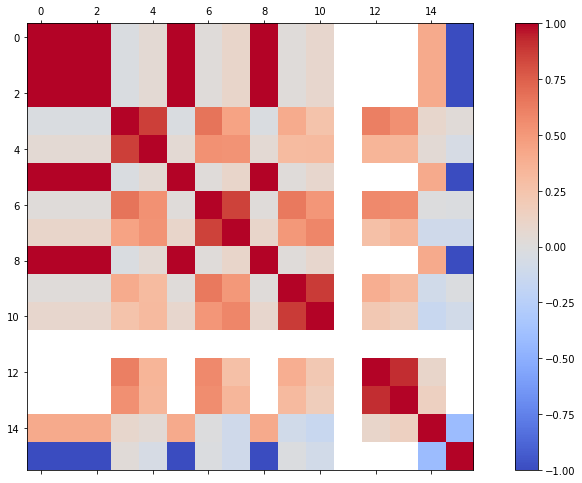

In [19]:
#@title Generar Matriz de Correlación 
# muestra la matriz
print('Matriz de Correlación:\n')
corr = ndf.corr() 
display( corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(3) )
print("\n")

# muestra la figura
fig = plt.figure(figsize=(15,8)) 
plt.matshow(corr,  fignum=fig.number, cmap='coolwarm')
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
#plt.title('Matriz de Correlación')
plt.show()

#Resultados de aplicar Algoritmos de Minería de Datos:

In [20]:
#@title Aplicar Descubrimiento de Reglas ( Decision Tree ) { run: "auto" }

# carga las columnas no numéricas
colValues, colNoValues = devolNombreColumnas(ndf)

if len(colNoValues)<1:
  raise ValueError("No se encuentra ningún atributo no numérico para utilizar como objetivo!!!")

selColumnas = widgets.SelectMultiple(
    options=colValues,
    value=list(colValues),
    description='Atr.Entrada:')

comboClase = widgets.Dropdown(
    options=colNoValues,
    value=(atributo_clase if atributo_clase!="" else colNoValues[0]),
    description='Atr.Clase:',
    disabled=False,
)

ui = widgets.HBox([selColumnas, comboClase])

def cambiaSeleccion(atributos_entrada, atributo_clase_tree):      
    # convierte la selección a un array 
    # agrega el atributo clase para mostrar
    cols = list(atributos_entrada)
    cols.append(atributo_clase_tree)                       
    arCols = np.array(cols)

    # obtiene los datos para entrenar el algoritmo
    X, Y, xColName = separarDatosXY(ndf[arCols], atributo_clase_tree, xSoloNros=True)

    # determina nombre de atributos y valores clase
    cols = xColName
    classvalues = np.unique(Y)

    # genera el árbol y lo muestra
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X, Y)

    # muestra el árbol
    plt.figure(figsize=(15,8))   
    tree.plot_tree(clf, 
                  feature_names=cols, 
                  class_names=classvalues, 
                  impurity=False, 
                  rounded=True, 
                  fontsize=11)
    plt.show()

out = widgets.interactive_output(cambiaSeleccion, {'atributos_entrada': selColumnas, 'atributo_clase_tree': comboClase})
display(ui, out)    

Output()

In [21]:
#@title Aplicar Ponderación ( Naive Bayes )

# carga las columnas numéricas y no numéricas
colValues, colNoValues = devolNombreColumnas(ndf)

if len(colNoValues)<1:
  raise ValueError("No se encuentra ningún atributo no numérico para utilizar como objetivo!!!")

# agrega los combos
comboEnt = widgets.Dropdown(
    options=colValues,
    value=colValues[0],
    description='Atr.Entrada:',
    disabled=False,
)

comboClase = widgets.Dropdown(
    options=colNoValues,
    value=colNoValues[0],
    description='Atr.Clase:',
    disabled=False,
)

ui = widgets.HBox([comboEnt, comboClase])

def cambiaSeleccion(atributo_valor_naiveBayes, atributo_clase_naiveBayes):
  # genera el gráfico
  plt.figure(figsize=(15,8))
  legValues = []   
  # procesa los valores del atributo clase
  for val in ndf[atributo_clase_naiveBayes].fillna("-NAN-").unique():
      # filtra los datos
      auxDF = ndf[ ndf[atributo_clase_naiveBayes] == val]
      # obtiene valores X, Y de clase y atributo
      Y = np.array(auxDF.pop(atributo_clase_naiveBayes).fillna("-NAN-"))
      X = np.array(auxDF[atributo_valor_naiveBayes].fillna(0.001))   
      if len(X)>0 and len(Y)>0:
        legValues.append(val)
        # calcula la densidad
        # instantiate and fit the KDE model
        kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
        kde.fit(X[:, None])      
        # score_samples returns the log of the probability density
        x_d = np.linspace(np.min(X), np.max(X), 1000)
        logprob = kde.score_samples(x_d[:, None])
        # genera área del atributo
        plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
        plt.plot(X, np.full_like(X, -0.01), '|k', markeredgewidth=1)
  plt.xlabel("Valores")
  plt.ylabel("Frecuencia")
  plt.legend(legValues, loc='best')
  plt.grid(color='lightgrey', which='major', axis='y', linestyle='solid', linewidth=0.3)
  plt.show()

out = widgets.interactive_output(cambiaSeleccion, {'atributo_valor_naiveBayes': comboEnt, 'atributo_clase_naiveBayes': comboClase })
display(ui, out)


Output()

In [22]:
#@title Aplicar Clustering ( K-Means ) { run: "auto" }

#@markdown Cantidad de clústeres a generar:
cantidad_clusters = 3 #@param {type:"integer"}
#@markdown Nombre del atributo clase / objetivo a descartar en el clustering:
atributo_clase_descartar_clustering = "" #@param {type:"string"}

# como mínimo se tienen que generar dos clusters
if cantidad_clusters < 2:
  cantidad_clusters = 2

# controla que exista el atributo_clase
if atributo_clase_descartar_clustering != "" and atributo_clase_descartar_clustering not in ndf:
  raise ValueError("El atributo '" + atributo_clase_descartar_clustering + "' no existe en los datos cargados!!!")

# obtiene los datos para entrenar el algoritmo
X, Y, colValues = separarDatosXY(ndf, atributo_clase_descartar_clustering, xSoloNros=True)
colValues = list(colValues)

# Entrena K-Means
kmeans = KMeans(n_clusters=cantidad_clusters).fit(X)
centroids = kmeans.cluster_centers_
print("Centroides Generados: \n", centroids)
print("\n")

# Determina la salida
labels = kmeans.predict(X)

# agrega los combos
comboColX = widgets.Dropdown(
    options=colValues,
    value=colValues[0],
    description='Columna X:',
    disabled=False,
)
if len(colValues)>1:
  valYsel = colValues[1]
else:
  valYsel = colValues[0]

comboColY = widgets.Dropdown(
    options=colValues,
    value=valYsel,
    description='Columna Y:',
    disabled=False,
)

ui = widgets.HBox([comboColX, comboColY])

def cambiaSeleccion(x, y):
  # llama a la función 
  # para generar el gráfico con las columnas seleccionadas
  plt.figure(figsize=(15,8))
  plt.scatter(X[:, colValues.index(x)], X[:, colValues.index(y)], c=labels)
  plt.show()

out = widgets.interactive_output(cambiaSeleccion, {'x': comboColX, 'y': comboColY})
display(ui, out)




Centroides Generados: 
 [[2.56000000e+02 2.56000000e+02 6.55360000e+04 5.90947481e+01
  8.15446315e+01 6.55360000e+04 5.00711405e+01 7.06772171e+01
  6.55360000e+04 3.56222380e+01 5.67842963e+01 1.00000001e-03
  1.00000000e-03 1.00000000e-03 3.59779412e+04 1.00000000e+00]
 [3.20000000e+02 3.20000000e+02 1.02400000e+05 5.88156909e+01
  8.52220980e+01 1.02400000e+05 5.55357265e+01 7.98094392e+01
  1.02400000e+05 4.19218988e+01 6.66044940e+01 1.02400000e+05
  9.34074714e+01 1.19616340e+02 3.96119070e+04 0.00000000e+00]
 [3.20000000e+02 3.20000000e+02 1.02400000e+05 5.47581250e+01
  7.99299678e+01 1.02400000e+05 3.89561121e+01 6.14058851e+01
  1.02400000e+05 2.33165734e+01 4.53196329e+01 1.02400000e+05
  9.43835920e+01 1.21325561e+02 9.26563529e+04 0.00000000e+00]]




Output()